In [42]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import yfinance as yf
import datetime as dt
import fredapi as fa
from scipy.stats import linregress

## Downloading the Prices

In [29]:
df_final = pd.DataFrame()
begin_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2022,11,17)
banks_tickes = ["JPM","BAC","WFC","MS","SCHW","GS","HSBC","C","^DJI","^GSPC","^RUT","SPY","DIA","IWM","QQQ"]
df_prices = yf.download(banks_tickes,start = begin_date,end=end_date,interval='1d')
df_prices = df_prices['Adj Close']
df_prices.reset_index(inplace=True)
df_prices['Date'] = pd.to_datetime(df_prices['Date']).dt.date
df_prices.set_index('Date',inplace=True)
df_prices.dropna(inplace=True)

[*********************100%***********************]  15 of 15 completed


## Calculating the returns

In [30]:
df_returns = round(df_prices.pct_change() * 100,2)
df_returns.dropna(inplace=True)
df_returns.head()

,BAC,C,DIA,GS,HSBC,IWM,JPM,MS,QQQ,SCHW,SPY,WFC,^DJI,^GSPC,^RUT
Date,,,,,,,,,,,,,,,
2000-05-30,0.57,3.54,2.24,3.13,1.37,3.69,4.26,5.20,10.05,6.93,3.26,1.13,2.21,3.22,4.23
2000-05-31,1.84,3.11,-0.12,2.17,-0.22,0.36,1.62,6.72,-2.85,7.11,0.22,0.84,-0.05,-0.13,-0.11
2000-06-01,2.48,1.81,1.13,3.82,1.57,2.27,3.26,5.24,5.11,0.89,1.75,1.52,1.23,1.99,3.42
2000-06-02,7.37,5.23,0.95,13.75,2.77,5.20,4.62,10.38,7.15,17.54,1.74,3.95,1.34,1.96,4.17
2000-06-05,-2.87,-0.28,0.68,-2.73,1.19,-0.37,-1.63,-1.13,0.25,-3.73,-0.49,-5.50,0.19,-0.65,0.05


## Correlation

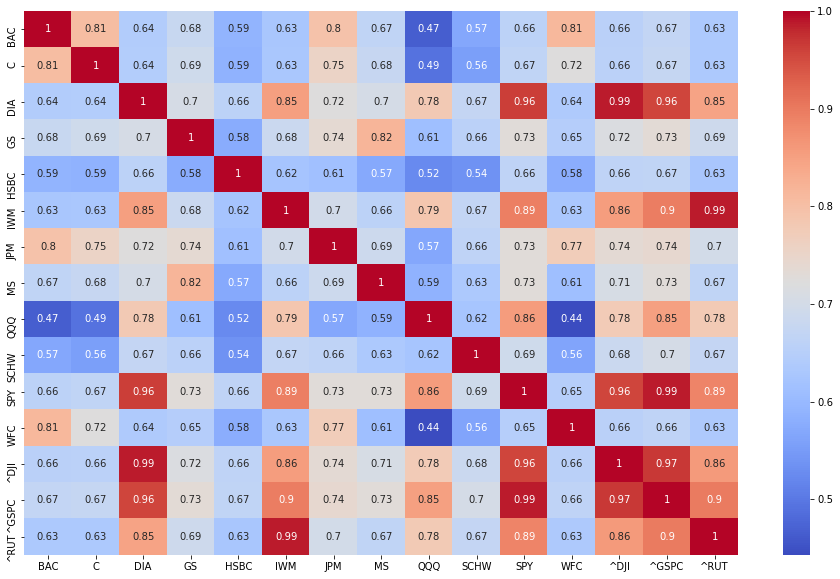

In [31]:
#df_returns.drop(["SPY","DIA","IWM"], axis = 1, inplace=True)

corr = df_returns.corr(method="pearson")
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(corr,annot=True,cmap="coolwarm")
plt.show()

### Correlation results - Banks WFC,TD,RY,MS,JPM,GS,C,BMO,BAC have a good correlation against the DJI, S&P500 and Russell 2000.

"SPY","DIA","IWM"

In [32]:
indexes = ["SPY","DIA","IWM","QQQ","^GSPC"]
banks_stock_tickers_corr = ["JPM","BAC","WFC","MS","SCHW","GS","HSBC","C"]
df_banks_corr_returns = pd.DataFrame()
df_banks_corr_returns['date'] = df_prices.index
df_banks_corr_returns.set_index('date',inplace=True)

In [33]:
# Building the dataframe only with the strongest correlation
for ticker in banks_stock_tickers_corr + indexes:
    df_banks_corr_returns[ticker] = df_returns[ticker]
df_banks_corr_returns.dropna(inplace=True)
df_banks_corr_returns.tail()

,JPM,BAC,WFC,MS,SCHW,GS,HSBC,C,SPY,DIA,IWM,QQQ,^GSPC
date,,,,,,,,,,,,,
2022-11-10,4.12,4.41,4.31,6.41,0.37,4.51,2.62,6.75,5.50,3.66,6.16,7.38,5.54
2022-11-11,0.16,0.73,-0.83,2.23,-0.25,1.81,0.72,3.66,0.97,0.16,0.82,1.84,0.92
2022-11-14,-1.03,-1.69,-1.43,-1.07,-2.41,-0.73,0.50,-2.33,-0.85,-0.60,-1.12,-0.88,-0.89
2022-11-15,-0.72,-0.16,-0.34,0.77,2.39,0.14,0.21,0.02,0.85,0.13,1.48,1.38,0.87
2022-11-16,0.14,-0.90,-1.07,-0.75,-1.14,-0.14,0.07,-1.35,-0.76,-0.04,-1.76,-1.36,-0.83


### Calculating and plotting the Linear Regression agains SP500/SPY as example 

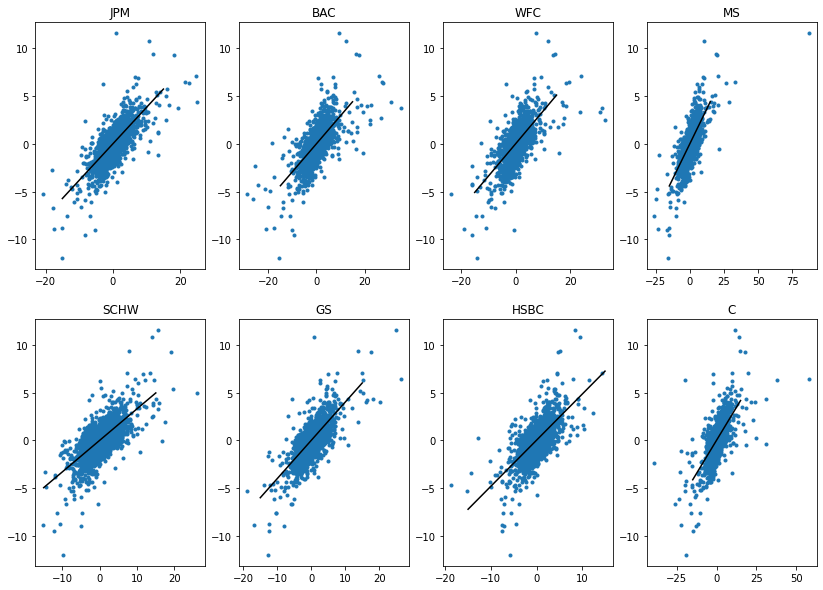

In [34]:
x_lr = np.linspace(-15,15)
ticker_pos = 0
fig,axs = plt.subplots(2,4,figsize=(14,10))
for x in range(2):
    for y in range(4):
        current_ticker = banks_stock_tickers_corr[ticker_pos]
        slope, intercept , r_value,p_value , std_err = linregress(df_banks_corr_returns[current_ticker],df_banks_corr_returns['^GSPC'])        
        axs[x,y].plot(df_banks_corr_returns[current_ticker],df_banks_corr_returns['^GSPC'],'.')
        axs[x,y].set_title(current_ticker)        
        axs[x,y].plot(x_lr,slope * x_lr + intercept, 'k')
        ticker_pos += 1


## Analyzing the price movements and its impact

   ### - Calculate the 200 days moving average for all the stocks
   ### - Check by date how many stocks are above the moving average
   ### - Build a dataframe with "date" , "number of stocks result", "percent of stocks"
   ### - identify if the percent of stocks for each date has any impact on the index price movements
   ### - The idea would be "buy" when the percent of stock reach below zero and sell after 6 months 

### 1 - Calculating the 200 moving average and also identify the number of stocks above the moving average by day
    
     The dictionary "total_high" is being used to store the quantity of stocks for specific day is above the moving average
     
      total_high["date"] = sum of tickers above the average for specific date

In [35]:
total_high = {}

for ticker in banks_stock_tickers_corr:
    df_tmp = pd.DataFrame(df_prices[ticker])
    df_tmp['MA200'] = df_tmp[ticker].rolling(200).mean()
    df_tmp['MMA200_high'] = np.where(df_tmp[ticker] > df_tmp['MA200'], 1, 0)
    df_tmp.dropna(inplace=True)
    for i,k in df_tmp.iterrows():
        if i not in total_high:
            if k['MMA200_high'] == 1:
                total_high[i] = 1
            else:
                total_high[i] = 0
        else:
            if k['MMA200_high'] == 1:
                total_high[i] += 1
            else:
                total_high[i] += 0               


### 2 - Creating a dataframe with the results of total_high and also adding a percent of stocks based on the quantity calculated before

In [36]:
final = pd.DataFrame()
final['date'] = total_high.keys()
final.set_index('date',inplace=True)
final['qty_high'] = total_high.values()
final['pct_high'] = round((final['qty_high'] / len(banks_stock_tickers_corr)) * 100,2)
final.tail()

,qty_high,pct_high
date,,
2022-11-10,6,75.0
2022-11-11,6,75.0
2022-11-14,6,75.0
2022-11-15,6,75.0
2022-11-16,6,75.0


### 3 - Calculating the buy signal when the percent of stock is < = 1

     "buy_signal" = 1 or 0

In [37]:
for index in indexes:
    final[index] = round(df_prices[index],2)
    final['buy_signal'] = np.where(final['pct_high'] <= 1,1,0)
    final = final[(final.index > datetime.date(2000,1,1))&(final.index < datetime.date(2023,1,1))]
final.head()

,qty_high,pct_high,SPY,buy_signal,DIA,IWM,QQQ,^GSPC
date,,,,,,,,
2001-03-13,3,37.5,79.84,0,63.16,34.79,38.31,1197.66
2001-03-14,2,25.0,78.27,0,61.52,33.96,37.71,1166.71
2001-03-15,2,25.0,78.29,0,61.65,33.83,36.33,1173.56
2001-03-16,2,25.0,76.72,0,60.50,33.20,35.51,1150.53
2001-03-19,2,25.0,78.28,0,61.34,34.07,37.29,1170.81


### 4 - identifying the buy signal, the date that has happened and creating a dataframe with the result 

In [38]:
buy_signal = []
for n in range(len(final)):
    if n > 0:      
        if final.iloc[n,3] == 1 :
            buy_signal.append({'date' : final.index[n],'value' : 1})                       

buy_signal = pd.DataFrame(buy_signal)
buy_signal

,date,value
0,2001-09-20,1
1,2001-09-21,1
2,2001-09-24,1
3,2001-10-08,1
4,2001-10-09,1
...,...,...
660,2022-10-14,1
661,2022-10-17,1
662,2022-10-18,1
663,2022-10-19,1


### 5 - Plotting the buy signal

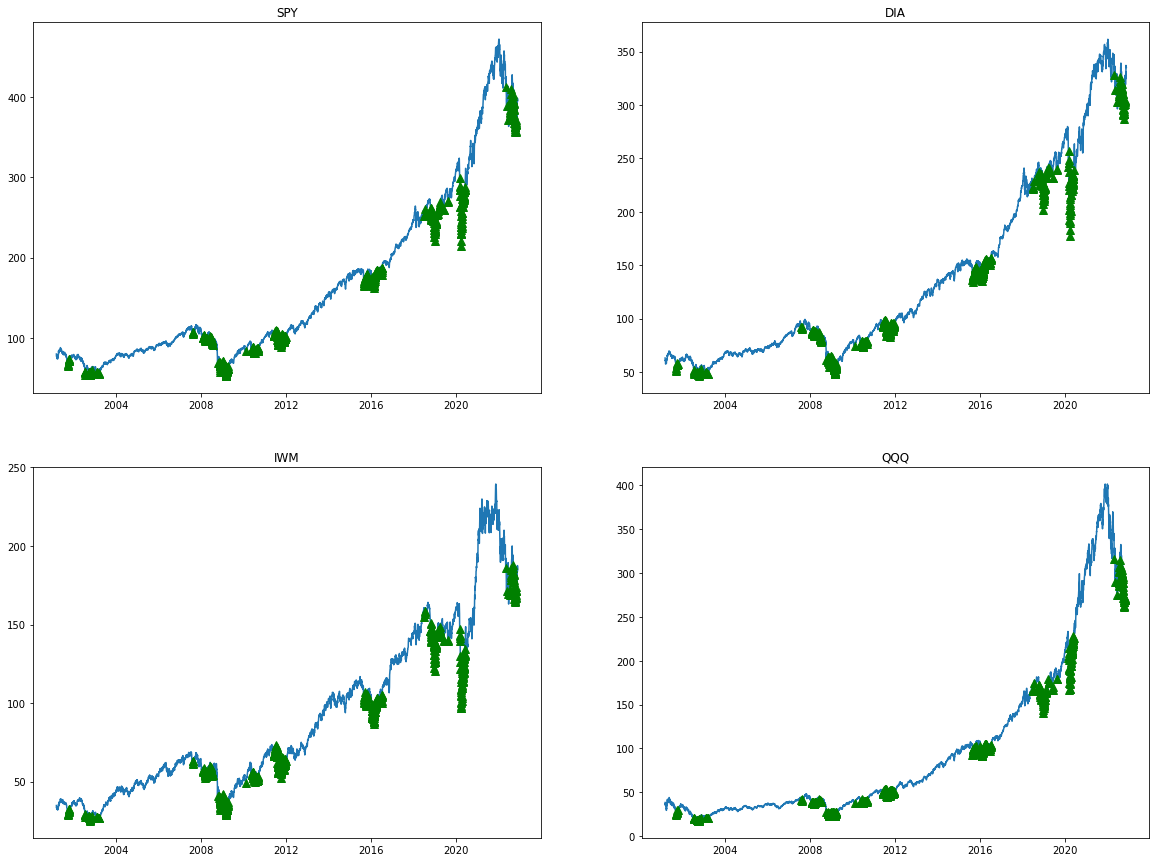

In [39]:
ticker_pos = 0

fig, axs = plt.subplots(2,2,figsize=(20,15))

for x in range(2):
    for y in range(2):
        current_ticker = indexes[ticker_pos]
        axs[x,y].plot(final.index,final[current_ticker],label=index)
        axs[x,y].plot(buy_signal['date'], final.loc[buy_signal['date']][current_ticker], '^', markersize=8, color='g')
        axs[x,y].set_title(current_ticker)
        ticker_pos += 1

plt.show()

### 6 - Buying with the signal and selling after 125 days

In [40]:
buy_indexes_results = {}

for index in indexes:
    buy_results = []
    for i,k in buy_signal.iterrows():
        trading_period = []
        buy_date = k['date']
        future_date = buy_date + dt.timedelta(days=125)
        trading_period = final.loc[buy_date : future_date]
        if len(trading_period) > 0:
            begin_value = trading_period.iloc[0,trading_period.columns.get_loc(index)]
            end_value = trading_period.iloc[-1,trading_period.columns.get_loc(index)]
            buy_results.append(round(((end_value - begin_value) / end_value) * 100,2))
    buy_indexes_results[index] = buy_results

### 7 - Returns

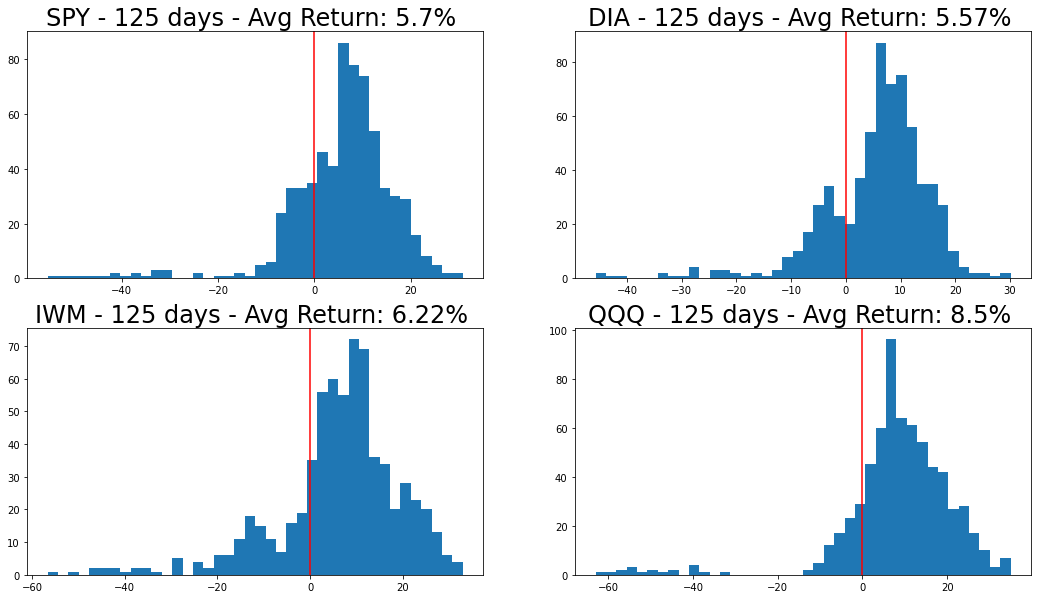

In [41]:
ticker_pos = 0
fig, axs = plt.subplots(2,2,figsize=(18,10))
for x in range(2):
    for y in range(2):
        current_ticker = indexes[ticker_pos]
        returns = buy_indexes_results[current_ticker]
        avg_return = round((sum(returns) / len(returns)),2)
        axs[x,y].hist(buy_indexes_results[current_ticker], bins=40)
        axs[x,y].axvline(x = 0, color = 'r')
        axs[x,y].set_title(f"{current_ticker} - 125 days - Avg Return: {avg_return}% ", fontsize=24)
        ticker_pos += 1
plt.show()

    
    